In [1]:
import geopandas as gpd

vm_map = gpd.read_file('./Census tract - Percentage of visible minority/Census tract - Percentage of visible minority, n.i.e..shp')

vm_map.rename(columns={'Value': 'Percentage of visible minority'}, inplace=True)

In [2]:
# read in the neighbourhood file and one of the census data files
toronto = gpd.read_file('./toronto_neighbourhoods/neighbourhood.shp')
da_home = gpd.read_file('./Dissemination area - Homeownership rate (%)/Dissemination area - Homeownership rate (%).shp')

toronto_proj = toronto.to_crs(epsg=2958)
vm_map_proj = vm_map.to_crs(epsg=2958)

In [3]:
# clip the census tract file to shape of toronto neighbourhoods to eliminate unneeded CTs
to_ct = gpd.clip(vm_map_proj, toronto_proj)

# write this to a file so it does not need to be done again
to_ct.to_file('toronto_ct_clipped.shp')

C:\Users\saman\AppData\Local\Temp\ipykernel_31280\1333297793.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  to_ct.to_file('toronto_ct_clipped.shp')
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Percentage of visible minority' to 'Percentage'
  ogr_write(


In [4]:
# read in Median household income census data
mmhh_map = gpd.read_file('./Census tract - Median total income of households in 2020 ($)/Census tract - Median total income of households in 2020 ($).shp')

# clean, clip, and project it
mmhh_map.rename(columns={'Value': 'Median total income of households in 2020 ($)'}, inplace=True)
mmhh_to = gpd.clip(mmhh_map.to_crs(epsg=2958), toronto_proj)

In [5]:
# read in Homeownership rate census data
hor_map = gpd.read_file('./Census tract - Homeownership rate (%)/Census tract - Homeownership rate (%).shp')

# clean, clip, and project it
hor_map.rename(columns={'Value': 'Homeownership rate (%)'}, inplace=True)
hor_to = gpd.clip(hor_map.to_crs(epsg=2958), toronto_proj)

In [6]:
# interpolate the data right away so the maps are all consistent and Nans are replaced via linear interpolation
# also a cleaner merger than you had below, removes some redundant columns and is clearer what you need and what you do not
to_ct_cleaned = to_ct[['DGUID', 'geometry']].merge(to_ct[['Percentage of visible minority', 'DGUID']].interpolate(),
                                                    how = 'left', on = 'DGUID')

# merge all the variables into one GeoDataFrame
to_all = (to_ct_cleaned.merge(mmhh_to[['Median total income of households in 2020 ($)', 'DGUID']].interpolate(),
                       how = 'left', on = 'DGUID')).merge(hor_to[['Homeownership rate (%)', 'DGUID']].interpolate(),
                                                            how = 'left', on = 'DGUID')

C:\Users\saman\AppData\Local\Temp\ipykernel_31280\3327785092.py:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  to_ct_cleaned = to_ct[['DGUID', 'geometry']].merge(to_ct[['Percentage of visible minority', 'DGUID']].interpolate(),
C:\Users\saman\AppData\Local\Temp\ipykernel_31280\3327785092.py:7: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  to_all = (to_ct_cleaned.merge(mmhh_to[['Median total income of households in 2020 ($)', 'DGUID']].interpolate(),
C:\Users\saman\AppData\Local\Temp\ipykernel_31280\3327785092.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  how = 'left', on = 'DGUID')).merge(hor_to[['Homeowner

In [7]:
# write this to a file so other code files can rely on this
to_all.to_file('toronto_census_all.shp')

C:\Users\saman\AppData\Local\Temp\ipykernel_31280\3017886130.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  to_all.to_file('toronto_census_all.shp')
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Percentage of visible minority' to 'Percentage'
  ogr_write(
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Median total income of households in 2020 ($)' to 'Median tot'
  ogr_write(
C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Homeownership rate (%)' to

<Axes: ylabel='Frequency'>

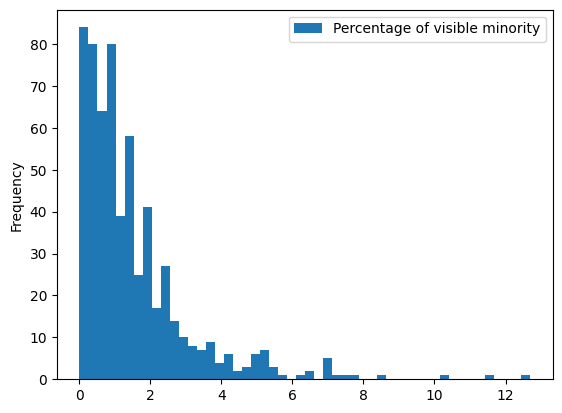

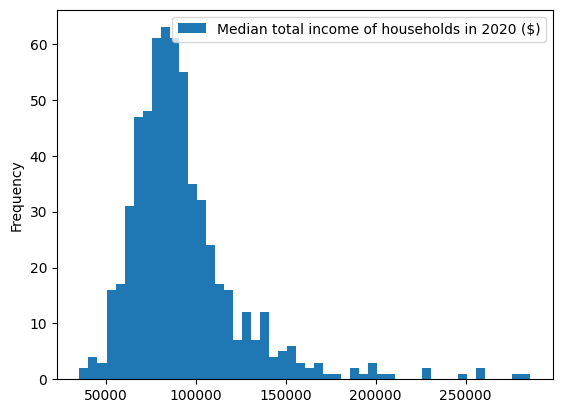

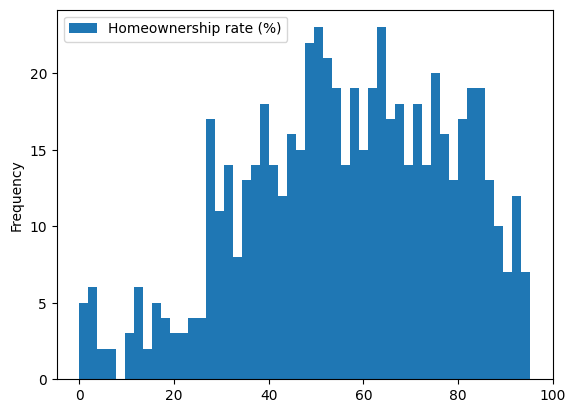

In [8]:
# visualize all the histograms to see what classification schemes are appropriate

to_all.plot(kind='hist', column = 'Percentage of visible minority', bins = 50)
to_all.plot(kind='hist', column = 'Median total income of households in 2020 ($)', bins = 50)
to_all.plot(kind='hist', column = 'Homeownership rate (%)', bins = 50)

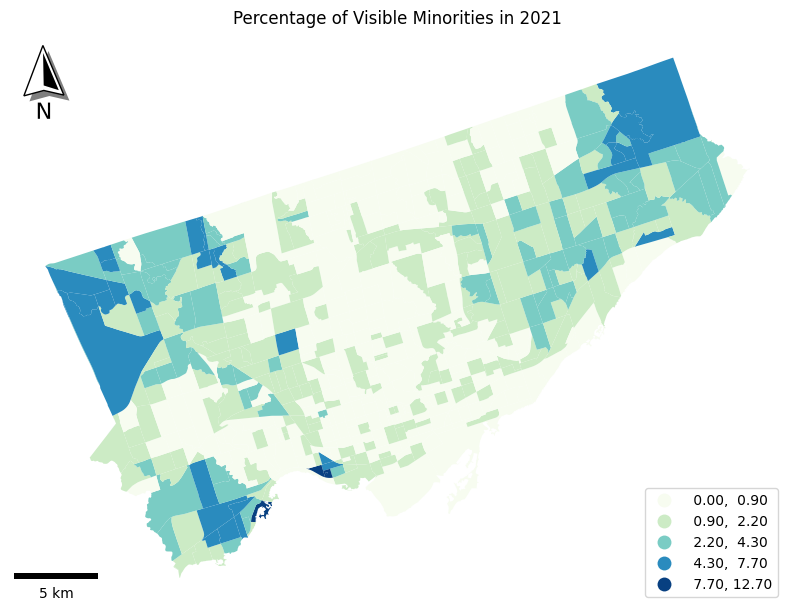

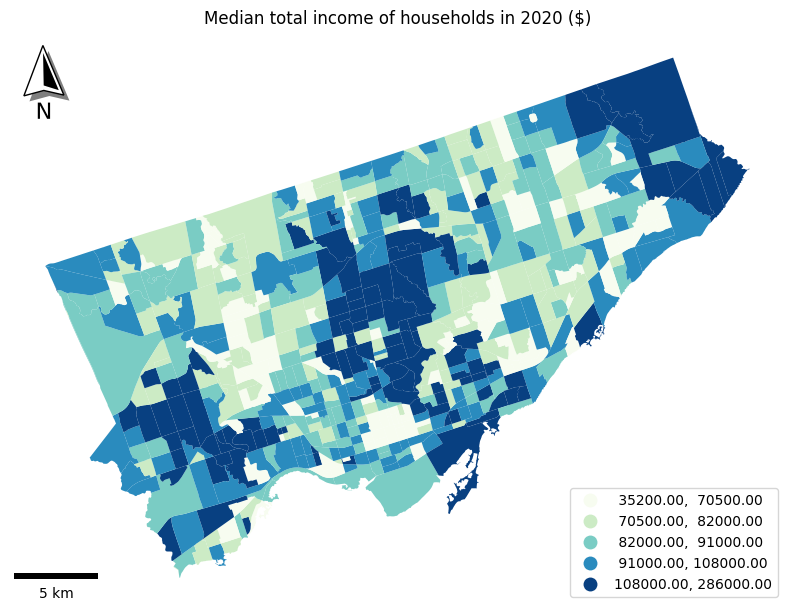

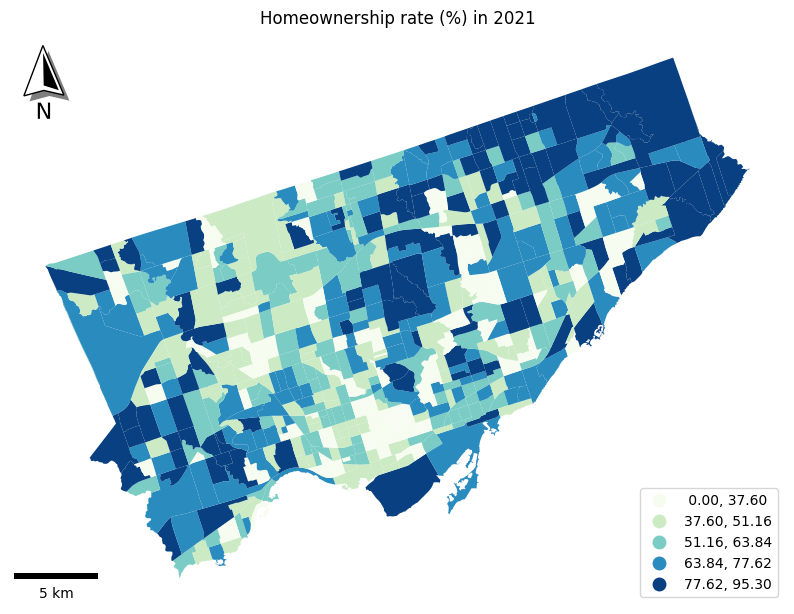

In [9]:
import plotter # our custom plotting module to ensure consistency

# plot them all individually in case these are needed in the report
f1, ax = plotter.plot_choropleth(to_all, 'Percentage of Visible Minorities in 2021', column = 'Percentage of visible minority', scheme = 'naturalbreaks')
f2, ax = plotter.plot_choropleth(to_all, 'Median total income of households in 2020 ($)', column = 'Median total income of households in 2020 ($)')
f3, ax = plotter.plot_choropleth(to_all, 'Homeownership rate (%) in 2021', column = 'Homeownership rate (%)')

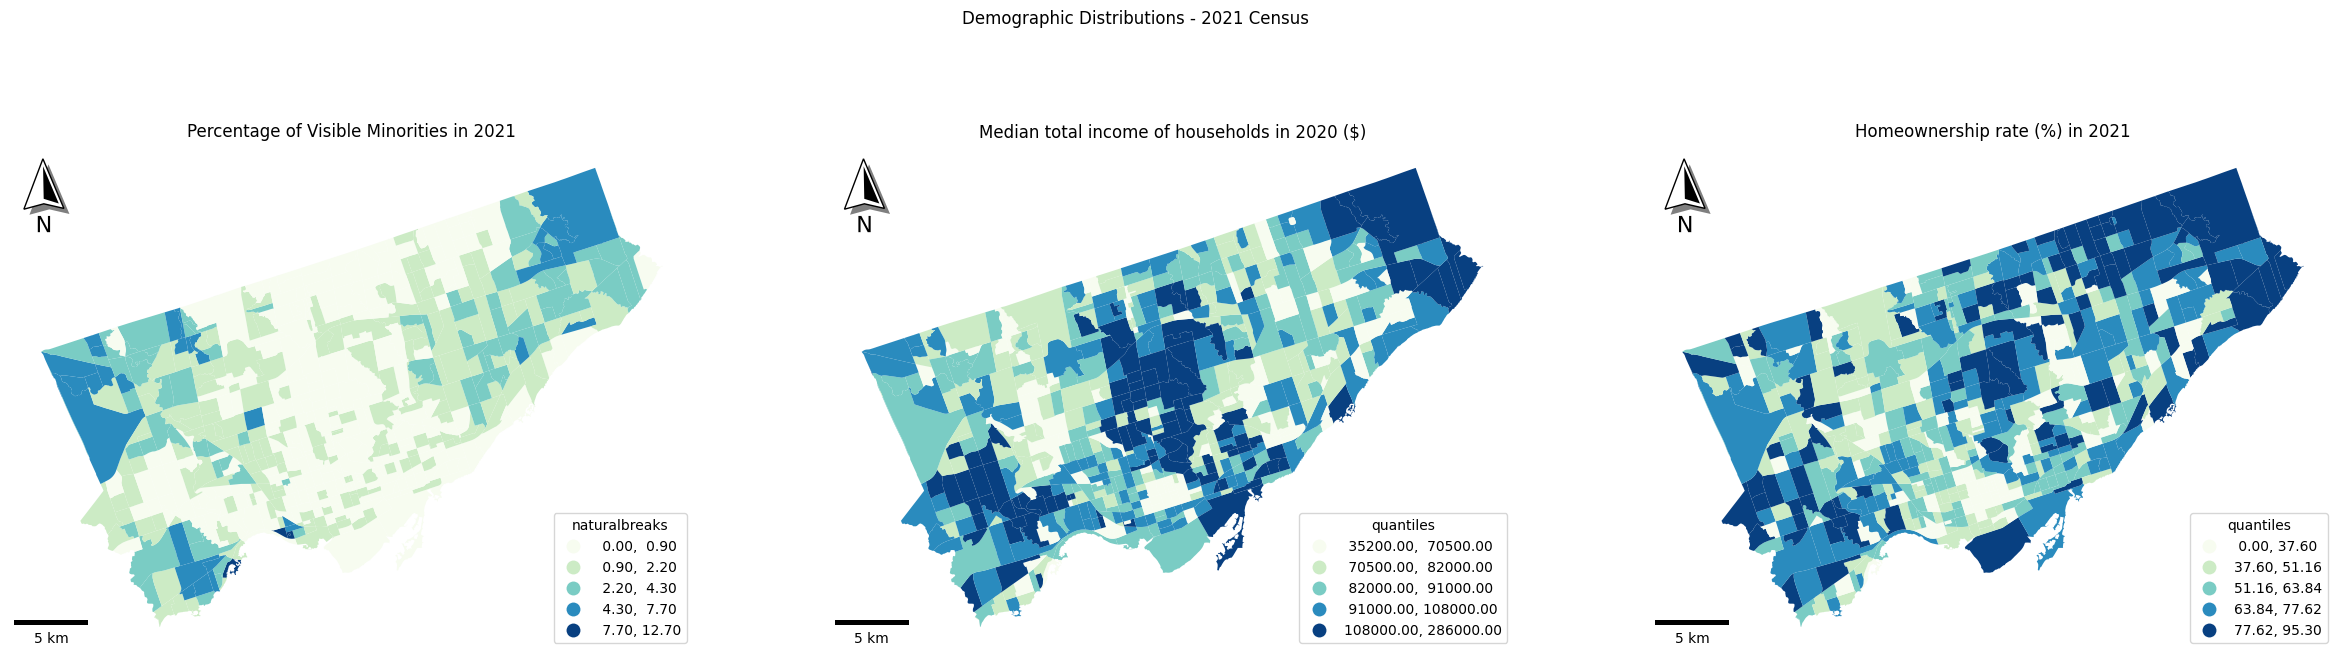

In [10]:
# plot them as one clean figure to use in report
f4, ax = plotter.plot_choropleths(to_all, suptitle='Demographic Distributions - 2021 Census',
                         titles = ['Percentage of Visible Minorities in 2021','Median total income of households in 2020 ($)', 'Homeownership rate (%) in 2021'],
                         columns = ['Percentage of visible minority', 'Median total income of households in 2020 ($)', 'Homeownership rate (%)'],
                         schemes = ['naturalbreaks', 'quantiles', 'quantiles'])

In [11]:
f1.savefig('Percentage of Visible Minority Figure')
f2.savefig('Median total income of households in 2020 ($) Figure')
f3.savefig('Homeownership rate (%) Figure')
f4.savefig('Combined Demographic Figure')